In [505]:
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load external data

In [313]:
freq = 'w'
risk_profile = 4
current_date='2020-03-30'

#### Prices

In [314]:
filepath = '../../data/external/'
filename = 'price_db_' + freq + '.pkl'
price_db = pd.read_pickle(filepath+filename)

Make `df_rt`, a matrix of log returns of all eligible **instruments** in the universe with:
- Columns: itemcode
- Rows: date

In [315]:
df_rt = price_db[price_db.itemtype=='ETF'].pivot(index='date', columns='itemcode', values='ret').dropna()

## Load portfolio constraints

In [316]:
import riskfolio.ConstraintsFunctions as cf
import utils

#### Load asset classification and constraints information
- `asset_classes` <- `universe` <- tradable_instruments.pkl left join with instruments_m.pkl
- `constraints` <- constraints.pkl

In [317]:
# instruments_m: 투자가능 종목들 목록 (현재 시점의 거래금액, 시총 보고 뽑음)
filepath = '../../data/processed/'
filename = 'instruments_m.pkl'
instruments_m = pd.read_pickle(filepath+filename)

# simulatable_instruments: 상장된 지 3년 넘은 종목 (시뮬레이션을 위해 필요한 요건)
filepath = '../../data/external/'
filename = 'simulatable_instruments.pkl'
simulatable_instruments = pd.read_pickle(filepath+filename)

# 사용자가 지정한 제약조건 테이블. Aw>=B 형식으로 되어 있어 사람이 이해하기 편함.
filepath = '../../data/processed/'
filename = 'constraints.pkl'
df_constraints = pd.read_pickle(filepath+filename)

universe = pd.merge(simulatable_instruments, instruments_m, left_on='itemcode', right_on='itemcode', how='left')

In [318]:
universe = universe.set_index(['itemcode'], drop=True).loc[df_rt.columns]
universe = universe.reset_index()

In [319]:
asset_classes = utils.get_asset_classes(universe)

#### Remove strategy constraints for now.

In [320]:
# df_constraints = df_constraints.drop(df_constraints[df_constraints.Set=='Strategy'].index)
# df_constraints = df_constraints.drop(df_constraints[df_constraints.Set=='DC risky asset'].index)

In [321]:
constraints = df_constraints[np.logical_or(
    df_constraints.risk_profile == str(risk_profile), df_constraints.risk_profile == 'Common')].drop(['risk_profile'], axis=1)

# constraints.loc[0, 'Type'] = 'Classes'
# constraints.loc[0, 'Weight'] = 0.4
# constraints.loc[0, 'Sign'] = '<='

# constraints.loc[10, 'Weight'] = 0.25
# constraints.loc[9, 'Factor'] = 5
# constraints.loc[11, 'Sign'] = '<='
# constraints.loc[11, 'Weight'] = 0.7
# constraints.loc[:, 'Disabled'] = False
# new_c = constraints.loc[4,:].copy()
# new_c['Sign'] = '>='
# new_c['Weight'] = 0.6
# constraints = pd.concat([pd.DataFrame(new_c).T, constraints]).reset_index(drop=True)

In [322]:
constraints

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
10,False,Classes,Asset class,Equity,>=,0.50,NaN,NaN,NaN,NaN
11,False,Classes,Asset class,Equity,<=,0.70,NaN,NaN,NaN,NaN
12,False,Classes,Asset class,Fixed Income,<=,0.50,NaN,NaN,NaN,NaN
13,False,Classes,Asset class,Alternative,<=,0.20,NaN,NaN,NaN,NaN
16,False,Classes,Strategy,Core,>=,NaN,Classes,Strategy,Satellite,1.5
17,False,All Assets,NaN,NaN,<=,0.25,NaN,NaN,NaN,NaN
18,False,Classes,DC risky asset,Y,<=,0.70,NaN,NaN,NaN,NaN
19,False,Classes,Issuer,KINDEX,<=,0.60,NaN,NaN,NaN,NaN
20,False,Classes,Issuer,KODEX,<=,0.60,NaN,NaN,NaN,NaN
21,False,Classes,Issuer,TIGER,<=,0.60,NaN,NaN,NaN,NaN


#### We have constraints matrice `A` and `B` such that
- $Aw \ge B$.

In [323]:
A, B = cf.assets_constraints(constraints, asset_classes)

## Estimaing mean risk portfolios

- Using ***CDaR*** instead of variance as a risk measure.
  - Conditional Drawdown at Risk(CDaR) is the average drawdown for all the instances that drawdown **exceeded** a certain threshold. Drawdown is a measure of downside risk.
  - https://breakingdownfinance.com/finance-topics/alternative-investments/conditional-drawdown-at-risk-cdar/

In [324]:
import riskfolio.Portfolio as pf
import datetime

`y` is a matrix of log returns of all eligible instruments in the universe.

In [325]:
current_date = '2020-06-10'
y = df_rt[df_rt.index <= current_date]

In [326]:
df_rf = price_db[price_db.itemtype=='riskfree'].set_index('date', drop=True)
current_idx = df_rf.index.asof(datetime.datetime.strptime(current_date, '%Y-%m-%d'))
rf = df_rf.loc[current_idx].price  # risk free rate

#### Set a log-return matrix `y`

In [327]:
port = pf.Portfolio(returns=y, sht=False, alpha=0.05) 

#### Set estimating methods
- `method_mu` to estimate expected returns.
- `method_cov` to estimated a covariance matrix.

In [328]:
method_mu='hist'  # Method to estimate expected returns; ewma with adjust=True. See pandas.DataFrame.ewm for more details.
method_cov='oas' # Method to estimate covariance matrix; ewma with adjust=True
decay=0.97

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=decay)

#### Apply constraints

In [432]:
port.ainequality = A
port.binequality = B

In [507]:
# Estimate optimal portfolio:
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'CDaR' # Risk measure used, this time will be variance
obj = 'MaxRet' if risk_profile==4 else 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf)

In [508]:
w = pd.merge(w, universe.loc[:,['itemcode', 'tracking_code', 'itemname']], left_index=True, right_on='itemcode', how='left')
w = w[['weights', 'tracking_code', 'itemcode', 'itemname']].set_index('itemcode', drop=True)
eps = 1e-09
w.loc[np.abs(w.weights)<eps,'weights'] = 0

#### Put small weights (<5%) into one category, namely, others.

In [509]:
small_wt = w[w.weights < 0.0495].weights.sum()
w_others = pd.DataFrame.from_dict(
    {'OTHERS': [w[w.weights < 0.0495].weights.sum(), 'Others', 'Others']},
    orient='index',
    columns=w.columns) if small_wt >= 0.00495 else None

In [510]:
w_summary = pd.concat([w.drop(w[w.weights<0.0495].index), w_others])

In [511]:
import plotly.express as px
fig = px.pie(w_summary, values='weights', names='tracking_code', title='Portfolio weights',
             labels=dict(zip(w_summary.tracking_code, w_summary.weights)), hole=0.5, width=600,
             color_discrete_sequence=px.colors.qualitative.Set3)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

## Show an efficient frontier

In [512]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,A069500,A091160,A091170,A091180,A102110,A102780,A105190,A114260,A122260,A130730,...,A214980,A229200,A232080,A245340,A245710,A251350,A266370,A273130,A278540,A283580
0,2.496590e-11,6.284712e-14,6.742759e-14,3.270464e-14,7.564043e-02,2.982307e-13,6.199791e-12,1.752070e-11,5.346147e-12,3.771156e-12,...,3.341504e-12,4.064752e-13,4.094458e-13,3.778805e-13,1.070175e-13,0.22436,1.023602e-13,0.250000,3.267654e-12,6.291595e-02
1,1.145771e-11,5.610623e-14,5.961684e-14,3.716055e-14,5.000000e-02,1.596388e-13,3.210753e-12,4.930636e-12,1.874969e-12,1.343324e-12,...,1.272336e-12,1.772738e-13,1.774777e-13,1.972822e-13,8.553976e-14,0.25000,1.251813e-13,0.250000,3.811887e-12,3.091583e-02
2,7.727770e-11,4.034439e-13,4.072787e-13,2.566292e-13,4.112829e-02,1.190694e-12,2.174841e-11,4.067030e-11,1.194836e-11,8.437853e-12,...,8.212442e-12,1.205276e-12,1.199889e-12,2.222109e-12,5.732626e-13,0.25000,1.013708e-12,0.250000,8.871706e-03,1.707870e-10
3,5.369887e-12,7.590063e-14,5.235537e-14,4.265283e-14,2.507241e-11,1.639676e-13,2.585674e-12,2.985168e-12,1.275803e-12,9.817642e-13,...,9.744439e-13,1.240141e-13,1.240610e-13,2.981146e-13,8.155623e-14,0.25000,1.595304e-13,0.250000,2.746556e-02,3.810755e-12
4,8.840532e-12,1.714315e-12,8.618482e-13,8.913940e-13,1.133513e-11,3.032529e-12,7.533341e-12,2.055875e-10,4.671702e-11,3.252979e-11,...,3.325986e-11,1.569652e-12,1.576543e-12,6.517893e-12,1.443385e-12,0.25000,3.546496e-12,0.249881,3.617365e-11,3.355745e-12


In [513]:
w

,weights,tracking_code,itemname
itemcode,,,
A069500,0.00,K200,KODEX 200
A091160,0.00,SEMI_KRX,KODEX 반도체
A091170,0.00,BANK_KRX,KODEX 은행
A091180,0.00,AUTO_KRX,KODEX 자동차
A102110,0.00,K200,TIGER 200
A102780,0.00,SAMSUNG_FN,KODEX 삼성그룹
A105190,0.00,K200,KINDEX 200
A114260,0.00,KTB_D3,KODEX 국고채3년
A122260,0.00,BOK_D1,KOSEF 통안채1년


In [514]:
w.drop('itemname', axis=1).set_index('tracking_code').T

tracking_code,K200,SEMI_KRX,BANK_KRX,AUTO_KRX,K200,SAMSUNG_FN,K200,KTB_D3,BOK_D1,MM,...,MM_PLUS,KQ150,KQ150,DOW30,VN30,MSCI_WO,IT,ACT_BOND_D4,MSCI_KR,CSI300
weights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.03,0.0,0.25,0.0,0.05,0.0,0.0


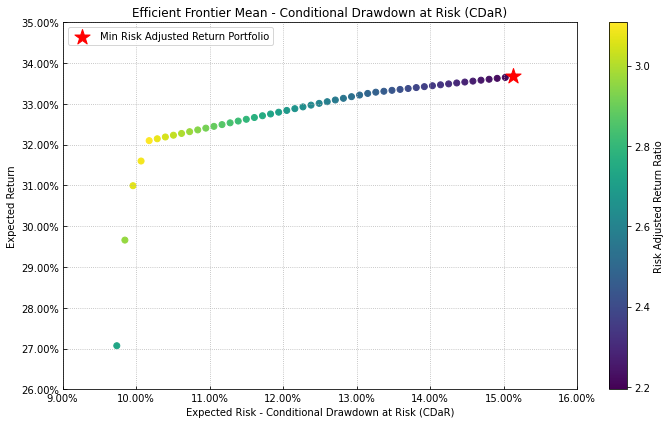

In [515]:
import riskfolio.PlotFunctions as plf

# Plotting the efficient frontier
label = 'Min Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = plf.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                       rf=rf, alpha=0.05, cmap='viridis', w=w.drop('itemname', axis=1).set_index('tracking_code'), label=label,
                       marker='*', s=16, c='r', height=6, width=10, ax=None)

In [516]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

In [517]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,UCI,EDaR
A069500,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A091160,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A091170,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A091180,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A102110,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A102780,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A105190,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A114260,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A122260,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A130730,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


In [519]:
port.numassets

26

In [524]:
int(4.1)

4

In [522]:
port.returns

itemcode,A069500,A091160,A091170,A091180,A102110,A102780,A105190,A114260,A122260,A130730,...,A214980,A229200,A232080,A245340,A245710,A251350,A266370,A273130,A278540,A283580
date,,,,,,,,,,,,,,,,,,,,,
2017-12-22,-0.016055,0.002246,0.014723,-0.009497,-0.015719,-0.023803,-0.013053,-0.001631,-0.000094,0.000197,...,0.000244,-0.001160,-0.002617,0.006670,0.008038,0.003277,-0.017569,-0.001054,-0.017401,0.018367
2017-12-28,0.020029,0.022442,0.013532,0.036058,0.020610,0.031108,0.019887,0.001279,0.000543,0.000353,...,0.000204,0.070055,0.068659,-0.010021,0.013734,-0.006565,0.025916,-0.000402,0.028319,-0.011875
2018-01-05,0.014234,-0.012456,0.020081,-0.038716,0.012980,0.027960,0.011011,0.000167,0.000897,0.000591,...,0.000651,0.041537,0.041930,0.001170,0.042859,0.015523,0.027933,-0.000050,0.015902,0.028461
2018-01-12,-0.007108,-0.032789,0.050556,-0.005146,-0.005997,0.012018,-0.004512,-0.001445,0.000198,0.000394,...,0.000498,0.105250,0.108399,0.020914,0.050623,0.008878,-0.031086,-0.001912,0.002541,0.019641
2018-01-19,0.009189,0.033729,-0.003993,0.042703,0.007677,0.001310,0.007508,-0.001002,0.000156,0.000352,...,0.000295,-0.017086,-0.018878,0.018013,-0.001308,0.013568,-0.006335,-0.000101,0.002535,0.029448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-08,-0.006206,0.062348,-0.035968,0.020824,-0.005645,-0.002336,-0.007953,0.002422,0.000547,0.000149,...,0.000293,0.060980,0.059625,-0.010046,0.058700,-0.003652,0.019433,0.004876,-0.007891,0.031066
2020-05-15,-0.011181,-0.009087,-0.038367,-0.037218,-0.011744,-0.002341,-0.010572,0.001727,0.000587,0.000488,...,0.000391,0.010358,0.011696,-0.018661,0.014256,-0.018092,-0.003147,0.003676,-0.012880,-0.011834
2020-05-22,0.021618,0.040258,-0.004237,0.048397,0.021834,0.026977,0.020647,0.000862,0.000288,0.000348,...,0.000342,0.009788,0.010641,0.039990,0.047163,0.027922,0.027974,0.001403,0.020770,-0.017291
